### Import Statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import sys
import copy
import math

In [2]:
%matplotlib inline

## Histogram Equalization ([Wikipedia]())

Histogram equalization is a method in image processing used **for adjusting contrast** in an image using the image's histogram. 

Histogram equalization **usually increases the global contrast** of many images, especially when the image is represented by a narrow range of intensity values. For example, brighter image will have most of the pixels confined to high intensity values and darker images will have most of the pixels confined to lower intensity values. 

Through this adjustment (histogram equalization), the intensities can be better distributed on the histogram utilizing the full range of intensities evenly. This allows for areas of lower local contrast to gain a higher contrast. Histogram equalization accomplishes this by effectively spreading out the highly populated intensity values which are used to degrade image contrast. 

<img src="./imgs/histogram_equalization.png">

**<u>Advantages of using Histogram Equalization</u>**
- The method is **useful in images with backgrounds and foregrounds that are both bright or both dark**. In particular, the method can lead to better views of bone structure in x-ray images, and to better detail in photographs that are either over or under-exposed. 
- In face recognition, before training the face data, the images of faces are histogram equalized to make them all with same lighting conditions.
- It is a fairly straightforward technique adaptive to the input image and an **invertible operator**. So in theory, if the histogram equalization function is known, then the original histogram can be recovered. The calculation is not computationally intensive. 
- It is very **useful for scientific images like thermal, satellite or x-ray images**, often the same class of **images to which one would apply false-color**.

**<u>Disdvantages</u>**
- A disadvantage of the method is that **it is indiscriminate**. It may increase the contrast of background noise, while decreasing the usable signal.
- Histogram equalization often produces **unrealistic effects** in photographs.
- Also histogram equalization can produce **undesirable effects** (like visible image gradient) when applied to images with low color depth. For example, if applied to 8-bit image displayed with 8-bit gray-scale palette it will further reduce color depth (number of unique shades of gray) of the image. 
- Histogram equalization will **work the best when applied to images with much higher color depth than palette size**, like continuous data or 16-bit gray-scale images. 

## Global Histogram Equalization ([Docs](https://docs.opencv.org/4.7.0/d5/daf/tutorial_py_histogram_equalization.html))

> The `cv.equalizeHise(src)` function is used for Histogram Equalization of 8 bit single channel images.

- Histogram Equalization of Grayscale Images

In [3]:
hawkes_bay_gray = cv.imread("./imgs/hawkes_bay_unequalized_gray.jpeg", 0)

In [4]:
hawkes_bay_gray_hist_equalized = cv.equalizeHist(hawkes_bay_gray)

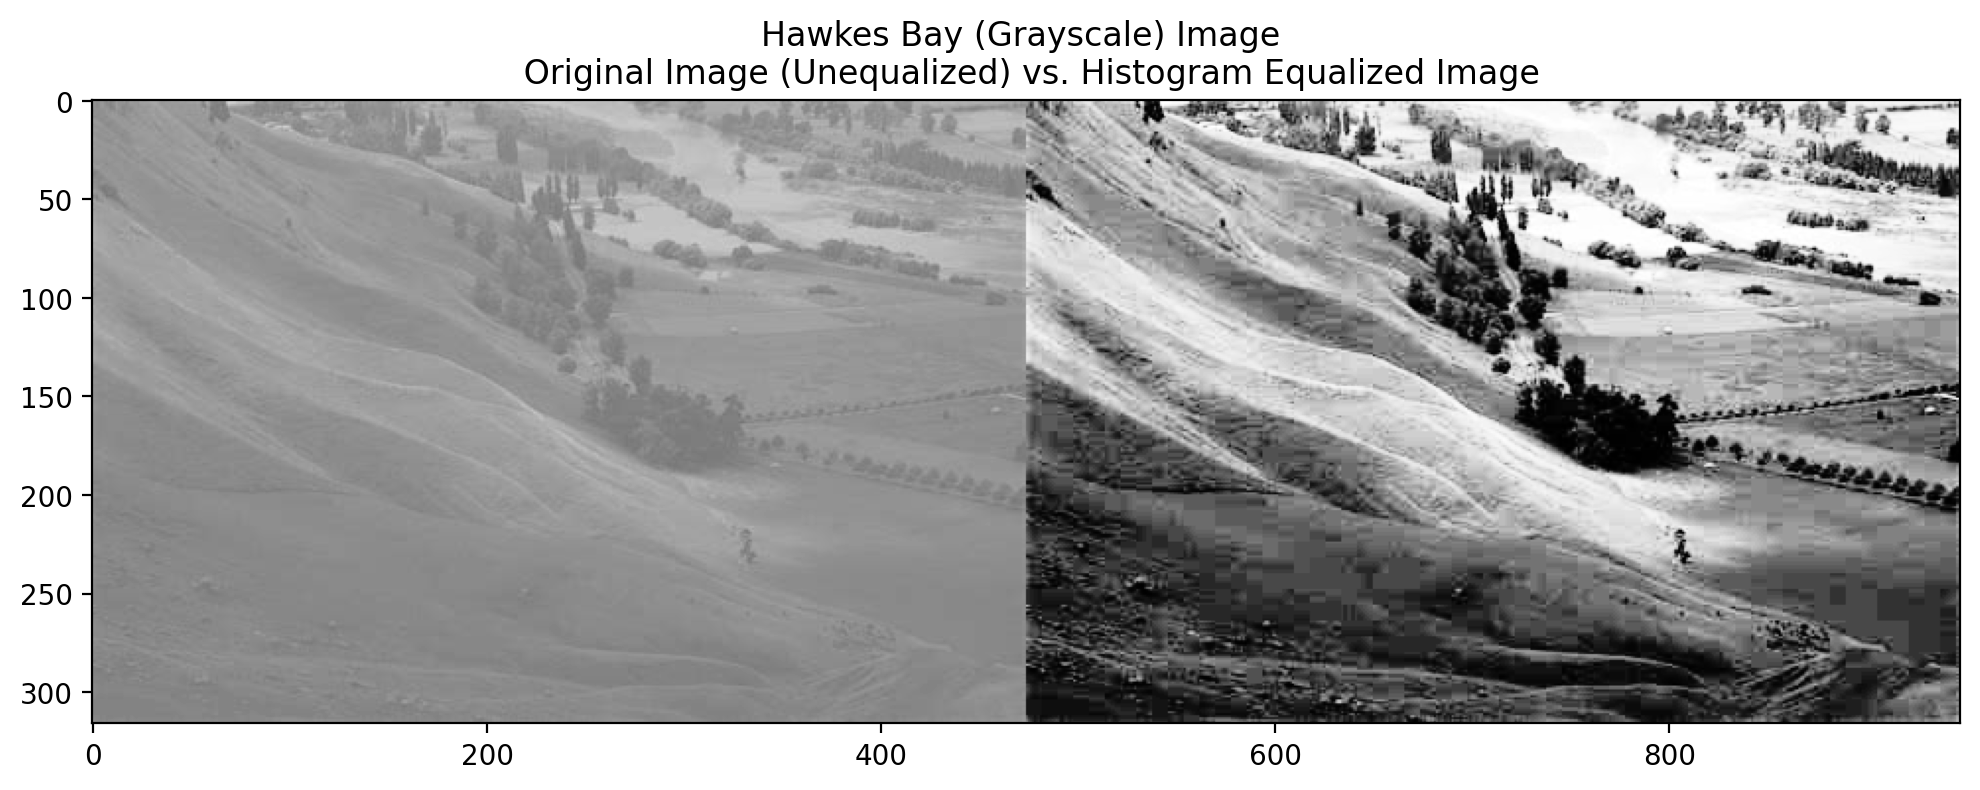

In [5]:
plt.figure(figsize=(10, 4), dpi=200)
plt.imshow(np.hstack((hawkes_bay_gray, hawkes_bay_gray_hist_equalized)), "gray")
plt.title(
    "Hawkes Bay (Grayscale) Image \n Original Image (Unequalized) vs. Histogram Equalized Image"
)

plt.tight_layout()
plt.show()

In [6]:
unequalized_hist = cv.calcHist(
    [hawkes_bay_gray], [0], None, histSize=[256], ranges=[0, 256]
)
equalized_hist = cv.calcHist(
    [hawkes_bay_gray_hist_equalized], [0], None, histSize=[256], ranges=[0, 256]
)

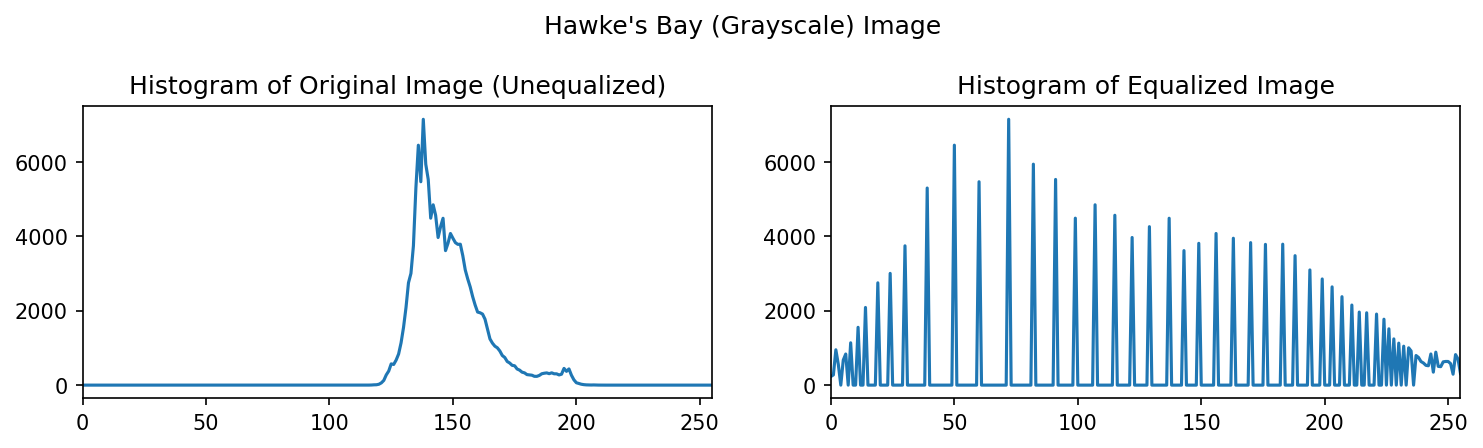

In [7]:
plt.figure(figsize=(10, 3), dpi=150)

plt.subplot(121), plt.plot(unequalized_hist), plt.title(
    "Histogram of Original Image (Unequalized)"
), plt.xlim(0, 255)
plt.subplot(122), plt.plot(equalized_hist), plt.title(
    "Histogram of Equalized Image"
), plt.xlim(0, 255)

plt.suptitle("Hawke's Bay (Grayscale) Image")

plt.tight_layout(w_pad=2)
# or, plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

plt.show()

- Histogram Equalization of Color Images ([Stackoverflow Post](https://stackoverflow.com/questions/15007304/histogram-equalization-not-working-on-color-image-opencv))

Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is not the proper way for equalization of contrast. 

Equalization involves Intensity values of the image and not the color components. So for a simple RGB color image, Histogram Equalization should not be applied individually on each channel. Rather, it should be applied such that intensity values are equalized without disturbing the color balance of the image. 

1. The first step is to convert the color space of the image from **BGR into** one of the color spaces which separate intensity values from color components. Some of these are: **HSV/HLS, YUV, YCrCb**. **YCrCb is preferred** as it is designed for digital images. 

2. Perform Histogram Equalization of the **intensity plane Y**. 

3. Lastly, convert the image **back to RGB**.

In [8]:
hawkes_bay_greenari = cv.cvtColor(
    cv.imread("./imgs/hawkes_bay_greeneries.jpeg"), cv.COLOR_BGR2RGB
)
hawkes_bay_greenari_ycrcb = cv.split(
    cv.cvtColor(hawkes_bay_greenari, cv.COLOR_RGB2YCrCb)
)

In [9]:
len(hawkes_bay_greenari_ycrcb)

3

In [10]:
hist_equalized_y = cv.equalizeHist(hawkes_bay_greenari_ycrcb[0])
hawkes_bay_greenari_hist_equalized = cv.cvtColor(
    cv.merge(
        [hist_equalized_y, hawkes_bay_greenari_ycrcb[1], hawkes_bay_greenari_ycrcb[2]]
    ),
    cv.COLOR_YCrCb2RGB,
)

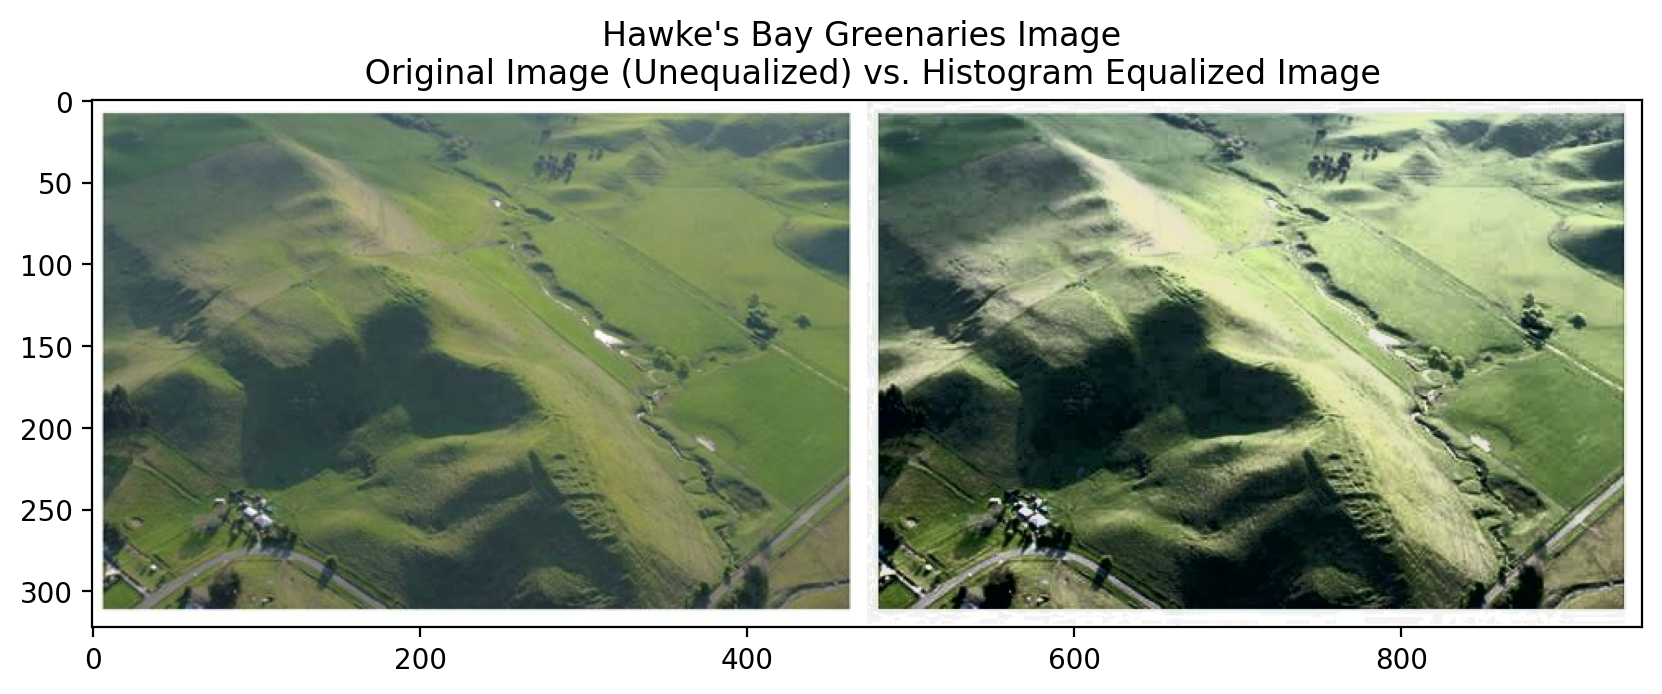

In [11]:
plt.figure(figsize=(10, 4), dpi=200)
plt.imshow(np.hstack((hawkes_bay_greenari, hawkes_bay_greenari_hist_equalized)))
plt.title(
    "Hawke's Bay Greenaries Image \n Original Image (Unequalized) vs. Histogram Equalized Image"
)

plt.show()

In [12]:
def color_hist(imgs, img_titles, suptitle, color_channels=["r", "g", "b"]):
    x = math.ceil(len(imgs) / 2)

    plt.figure(figsize=(10, 3), dpi=150)

    for i, img in enumerate(imgs):
        for c, color in enumerate(color_channels):
            hist_color = cv.calcHist([img], [c], None, histSize=[256], ranges=[0, 256])
            plt.subplot(x, 2, i + 1), plt.plot(hist_color, color=color)

        plt.title(img_titles[i])
        plt.xlim(0, 255)

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

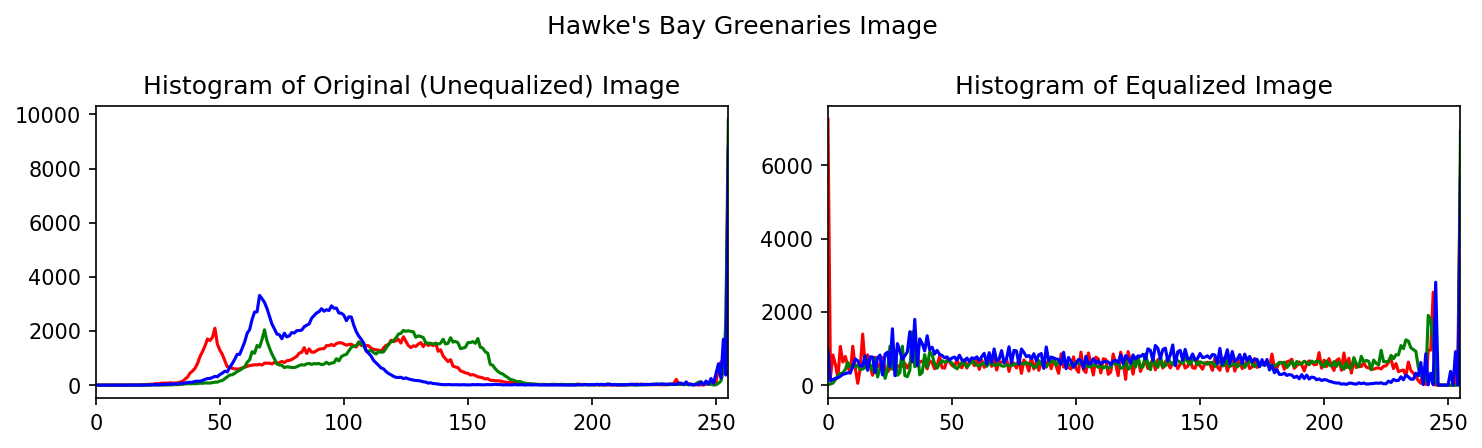

In [13]:
color_hist(
    [hawkes_bay_greenari, hawkes_bay_greenari_hist_equalized],
    ["Histogram of Original (Unequalized) Image", "Histogram of Equalized Image"],
    "Hawke's Bay Greenaries Image",
)

## CLAHE (Contrast Limited Adaptive Histogram Equalization) 

- ### Why Adaptive Histogram Equalization?

The histogram equalizations we saw above, considers the global contrast of the image. In many cases, it is not a good idea. For example, below image shows an input image and its result after global histogram equalization.

In [14]:
reading_room_gray = cv.imread("./imgs/reading_room.jpeg", 0)
reading_room_gray_hist = cv.calcHist(reading_room_gray, [0], None, [256], [0, 256])

reading_room_gray_hist_equalized = cv.equalizeHist(reading_room_gray)
reading_room_gray_hist_equalized_hist = cv.calcHist(
    reading_room_gray_hist_equalized, [0], None, [256], [0, 256]
)

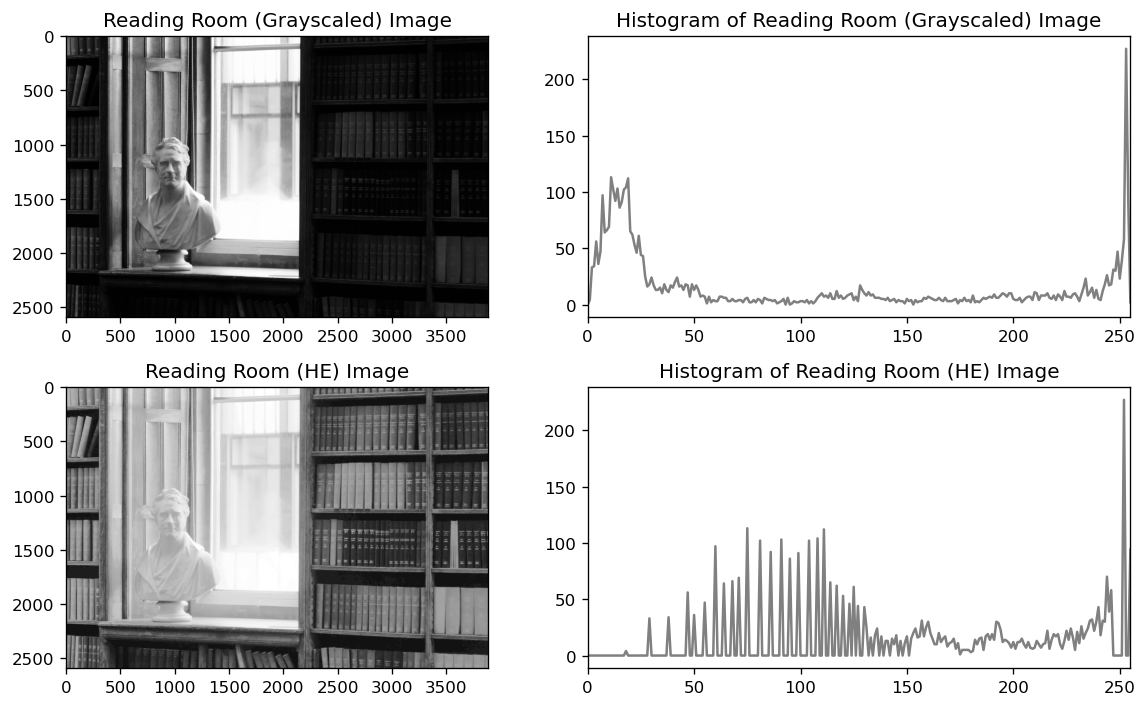

In [15]:
plt.figure(figsize=(10, 6), dpi=120)

plt.subplot(221), plt.imshow(reading_room_gray, "gray"), plt.title(
    "Reading Room (Grayscaled) Image"
)
plt.subplot(222), plt.plot(reading_room_gray_hist, "gray"), plt.title(
    "Histogram of Reading Room (Grayscaled) Image"
), plt.xlim(0, 255)

plt.subplot(223), plt.imshow(reading_room_gray_hist_equalized, "gray"), plt.title(
    "Reading Room (HE) Image"
)
plt.subplot(224), plt.plot(reading_room_gray_hist_equalized_hist, "gray"), plt.title(
    "Histogram of Reading Room (HE) Image"
), plt.xlim(0, 255)

plt.tight_layout()
plt.show()

In the Histogram Equalized version of the "Reading Room (Grayscaled) Image", it is true that the background contrast has improved after histogram equalization. But if we **compare the face of statue in both images**, we see that **we lost most of the information there due to over-brightness**. **It is because its histogram is not confined to a particular region as we saw in previous cases**.

So to solve this problem, adaptive histogram equalization is used.

- ### How Contrast Limited Adaptive Histogram Equalization (CLAHE) Works?

1. The image is divided into small blocks called "tiles" (tile size is 8x8 by default in OpenCV). 

2. Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. 

3. To avoid noise amplification, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. 

4. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied.

> The `cv.createCLAHE(clipLimit=40, tileGridSize=(8, 8))` function is used to create a `CLAHE` object. It is then used to apply CLAHE operation to the image using `CLAHE.apply(img)`.

In [16]:
CLAHE = cv.createCLAHE(clipLimit=5, tileGridSize=(16, 16))
reading_room_gray_clahe_equalized = CLAHE.apply(reading_room_gray)
reading_room_gray_clahe_equalized_hist = cv.calcHist(
    reading_room_gray_clahe_equalized, [0], None, [256], [0, 256]
)

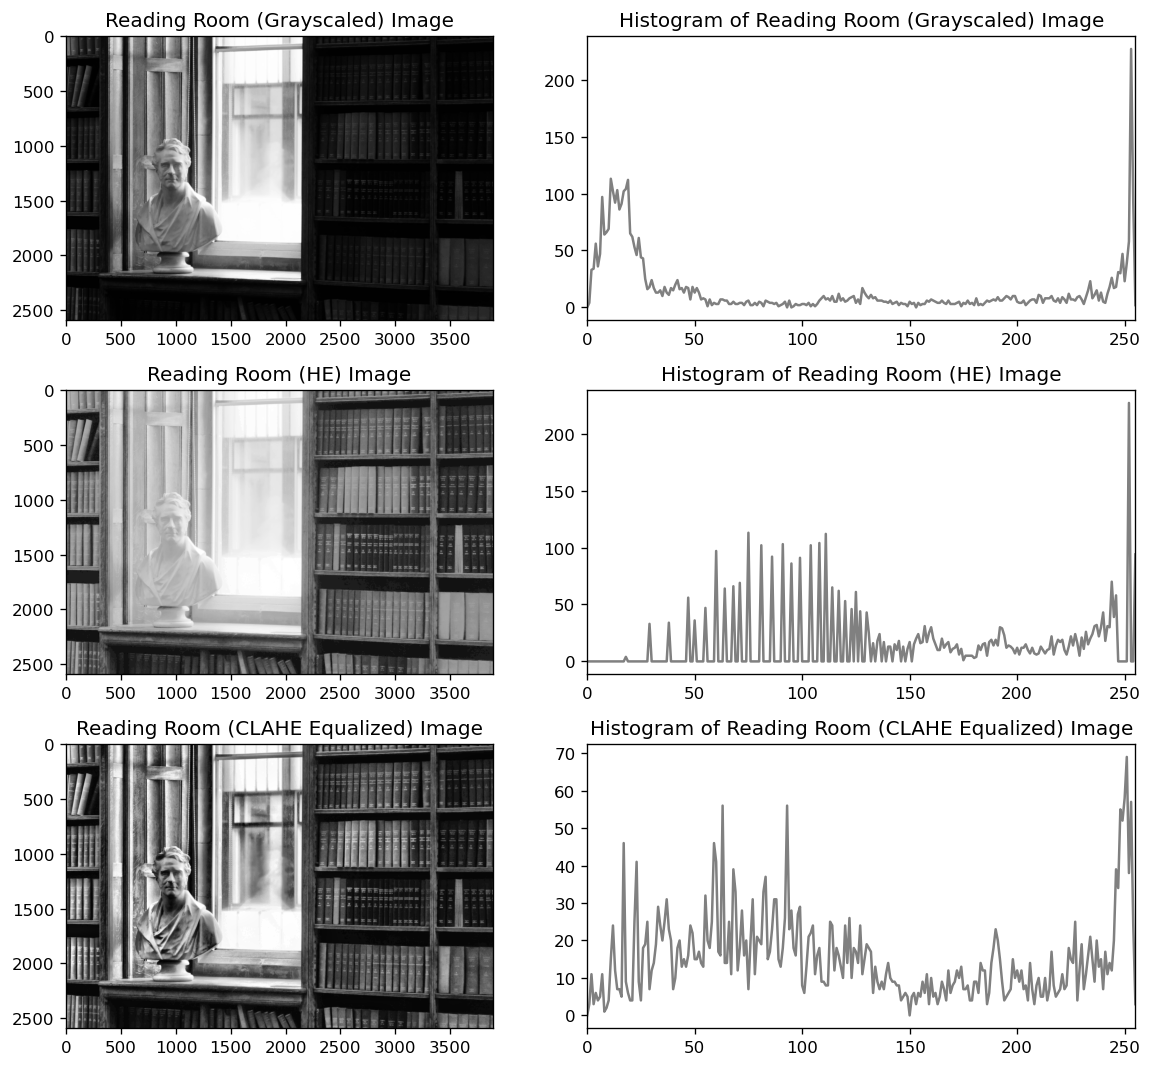

In [17]:
plt.figure(figsize=(10, 9), dpi=120)

plt.subplot(321), plt.imshow(reading_room_gray, "gray"), plt.title(
    "Reading Room (Grayscaled) Image"
)
plt.subplot(322), plt.plot(reading_room_gray_hist, "gray"), plt.title(
    "Histogram of Reading Room (Grayscaled) Image"
), plt.xlim(0, 255)

plt.subplot(323), plt.imshow(reading_room_gray_hist_equalized, "gray"), plt.title(
    "Reading Room (HE) Image"
)
plt.subplot(324), plt.plot(reading_room_gray_hist_equalized_hist, "gray"), plt.title(
    "Histogram of Reading Room (HE) Image"
), plt.xlim(0, 255)

plt.subplot(325), plt.imshow(reading_room_gray_clahe_equalized, "gray"), plt.title(
    "Reading Room (CLAHE Equalized) Image"
)
plt.subplot(326), plt.plot(reading_room_gray_clahe_equalized_hist, "gray"), plt.title(
    "Histogram of Reading Room (CLAHE Equalized) Image"
), plt.xlim(0, 255)

plt.tight_layout()
plt.show()